In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_absolute_error
from keras.callbacks import History
from keras.callbacks import Callback

In [25]:
df = pd.read_csv('./Processed_Dataset.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop(columns=['Xylene','Toluene','Benzene','NO','NO2'])
df['Datetime'] = pd.to_datetime(df['Datetime'])

df.head()

,Datetime,PM2.5,PM10,NOx,NH3,CO,SO2,O3,AQI
0,2017-11-24 17:00:00,60.50,98.00,18.25,8.50,0.1,11.85,126.40,95.59999
1,2017-11-24 18:00:00,65.50,111.25,15.07,9.77,0.1,13.17,117.12,95.59999
2,2017-11-24 19:00:00,80.00,132.00,15.15,12.02,0.1,12.08,98.98,95.59999
3,2017-11-24 20:00:00,81.50,133.25,10.23,11.58,0.1,10.47,112.20,95.59999
4,2017-11-24 21:00:00,75.25,116.00,10.43,12.03,0.1,9.12,106.35,95.59999


In [26]:
def create_sequence(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps + 1):
        sequences.append(data[i:i + timesteps])
    return np.array(sequences)

In [27]:
X = df.drop(columns=['AQI','Datetime'])
y = df['AQI']

# Hitung jumlah sampel untuk data latih (80%) dan data uji (20%)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

# Bagi data menjadi data latih dan data uji berdasarkan jumlah sampel yang dihitung
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [28]:
# Mengubah data menjadi urutan dengan panjang 48 timestep
X_train = create_sequence(X_train, 24)
X_test  = create_sequence(X_test, 24)

# Menyesuaikan panjang y_train dan y_test
y_train = y_train[-X_train.shape[0]:]
y_test  = y_test[-X_test.shape[0]:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18204, 24, 7)
X_test shape: (4534, 24, 7)
y_train shape: (18204,)
y_test shape: (4534,)


In [29]:
# Callback untuk menyimpan R-squared dan MAE setiap epoch
class MetricsHistory(Callback):
    def on_train_begin(self, logs={}):
        self.r2_scores = []
        self.mae_scores = []

    def on_epoch_end(self, epoch, logs={}):
        X_val_lstm = X_test
        y_pred = self.model.predict(X_val_lstm)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        self.r2_scores.append(r2)
        self.mae_scores.append(mae)
        
        print(f'Epoch {epoch+1} - MAE: {mae:.6f}')

In [30]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_absolute_error

# Inisialisasi model Sequential
model_lstm = Sequential()

# Tambahkan lapisan LSTM dengan 50 unit dan input_shape=(1, jumlah_fitur)
model_lstm.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[-1]), return_sequences=False))

# Tambahkan lapisan Dense dengan 1 neuron (untuk output regresi)
model_lstm.add(Dense(1))

# Kompilasi model dengan mean squared error sebagai loss function dan optimizer adam
model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

# Inisialisasi callback untuk menyimpan R-squared
callback = MetricsHistory()

# Latih model menggunakan data latih dengan callback R2History
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, callbacks=[callback])

# Prediksi menggunakan data uji
y_pred_lstm = model_lstm.predict(X_test)

Epoch 1/50
142/142 [==============================] - 1s 3ms/step
Epoch 1 - MAE: 33.828041
285/285 - 4s - loss: 87.2406 - 4s/epoch - 15ms/step
Epoch 2/50
142/142 [==============================] - 0s 3ms/step
Epoch 2 - MAE: 21.485839
285/285 - 2s - loss: 65.7967 - 2s/epoch - 8ms/step
Epoch 3/50
142/142 [==============================] - 0s 3ms/step
Epoch 3 - MAE: 18.939090
285/285 - 2s - loss: 53.1204 - 2s/epoch - 8ms/step
Epoch 4/50
142/142 [==============================] - 0s 3ms/step
Epoch 4 - MAE: 17.990896
285/285 - 2s - loss: 44.6687 - 2s/epoch - 9ms/step
Epoch 5/50
142/142 [==============================] - 0s 2ms/step
Epoch 5 - MAE: 16.053114
285/285 - 2s - loss: 37.7297 - 2s/epoch - 7ms/step
Epoch 6/50
142/142 [==============================] - 0s 3ms/step
Epoch 6 - MAE: 15.839129
285/285 - 2s - loss: 32.0633 - 2s/epoch - 8ms/step
Epoch 7/50
142/142 [==============================] - 0s 3ms/step
Epoch 7 - MAE: 13.050758
285/285 - 2s - loss: 29.6564 - 2s/epoch - 9ms/step
Epoch

In [31]:
standardscalerdf = df
standardscalerdf['Datetime'] = pd.to_datetime(standardscalerdf['Datetime'])

datetime = standardscalerdf[['Datetime']]
aqi = standardscalerdf[['AQI']]

standardscalerdf = standardscalerdf.drop(columns=['Datetime','AQI'])

standardscalerdf.head()

,PM2.5,PM10,NOx,NH3,CO,SO2,O3
0,60.50,98.00,18.25,8.50,0.1,11.85,126.40
1,65.50,111.25,15.07,9.77,0.1,13.17,117.12
2,80.00,132.00,15.15,12.02,0.1,12.08,98.98
3,81.50,133.25,10.23,11.58,0.1,10.47,112.20
4,75.25,116.00,10.43,12.03,0.1,9.12,106.35


In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_data = scaler.fit_transform(standardscalerdf)

# Konversi scaled_data kembali menjadi DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=standardscalerdf.columns)

# Gabungkan scaled_df dengan date_column
result_df = pd.concat([datetime, scaled_df, aqi], axis=1)

standardscalerdf = result_df

standardscalerdf.head()

,Datetime,PM2.5,PM10,NOx,NH3,CO,SO2,O3,AQI
0,2017-11-24 17:00:00,0.798129,0.454830,0.196889,-0.584394,-1.076443,-0.190467,3.506879,95.59999
1,2017-11-24 18:00:00,0.979525,0.742129,-0.009747,-0.377389,-1.076443,-0.078478,3.138017,95.59999
2,2017-11-24 19:00:00,1.505572,1.192050,-0.004549,-0.010648,-1.076443,-0.170954,2.416987,95.59999
3,2017-11-24 20:00:00,1.559990,1.219154,-0.324250,-0.082366,-1.076443,-0.307546,2.942456,95.59999
4,2017-11-24 21:00:00,1.333246,0.845123,-0.311254,-0.009018,-1.076443,-0.422080,2.709930,95.59999


In [33]:
X = standardscalerdf.drop(columns=['AQI','Datetime'])
y = standardscalerdf['AQI']

# Hitung jumlah sampel untuk data latih (80%) dan data uji (20%)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

# Bagi data menjadi data latih dan data uji berdasarkan jumlah sampel yang dihitung
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [34]:
# Mengubah data menjadi urutan dengan panjang 48 timestep
X_train = create_sequence(X_train, 24)
X_test  = create_sequence(X_test, 24)

# Menyesuaikan panjang y_train dan y_test
y_train = y_train[-X_train.shape[0]:]
y_test  = y_test[-X_test.shape[0]:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18204, 24, 7)
X_test shape: (4534, 24, 7)
y_train shape: (18204,)
y_test shape: (4534,)


In [35]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_absolute_error

# Inisialisasi model Sequential
model_lstm = Sequential()

# Tambahkan lapisan LSTM dengan 50 unit dan input_shape=(1, jumlah_fitur)
model_lstm.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[-1]), return_sequences=False))

# Tambahkan lapisan Dense dengan 1 neuron (untuk output regresi)
model_lstm.add(Dense(1))

# Kompilasi model dengan mean squared error sebagai loss function dan optimizer adam
model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

# Inisialisasi callback untuk menyimpan R-squared
callback2 = MetricsHistory()

# Latih model menggunakan data latih dengan callback R2History
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, callbacks=[callback2])

# Prediksi menggunakan data uji
y_pred_lstm = model_lstm.predict(X_test)

Epoch 1/50
142/142 [==============================] - 1s 5ms/step
Epoch 1 - MAE: 33.447152
285/285 - 8s - loss: 85.5326 - 8s/epoch - 29ms/step
Epoch 2/50
142/142 [==============================] - 1s 5ms/step
Epoch 2 - MAE: 21.414207
285/285 - 4s - loss: 65.5648 - 4s/epoch - 15ms/step
Epoch 3/50
142/142 [==============================] - 1s 5ms/step
Epoch 3 - MAE: 20.655445
285/285 - 4s - loss: 53.0857 - 4s/epoch - 14ms/step
Epoch 4/50
142/142 [==============================] - 1s 5ms/step
Epoch 4 - MAE: 14.195820
285/285 - 4s - loss: 45.2945 - 4s/epoch - 14ms/step
Epoch 5/50
142/142 [==============================] - 1s 5ms/step
Epoch 5 - MAE: 11.952455
285/285 - 4s - loss: 35.8722 - 4s/epoch - 14ms/step
Epoch 6/50
142/142 [==============================] - 1s 5ms/step
Epoch 6 - MAE: 10.966500
285/285 - 4s - loss: 29.3269 - 4s/epoch - 13ms/step
Epoch 7/50
142/142 [==============================] - 1s 5ms/step
Epoch 7 - MAE: 9.820696
285/285 - 4s - loss: 26.3803 - 4s/epoch - 14ms/step


In [36]:
minmaxdf = df
minmaxdf['Datetime'] = pd.to_datetime(minmaxdf['Datetime'])

datetime = minmaxdf[['Datetime']]
aqi = minmaxdf[['AQI']]

minmaxdf = minmaxdf.drop(columns=['Datetime','AQI'])

minmaxdf.head()

,PM2.5,PM10,NOx,NH3,CO,SO2,O3
0,60.50,98.00,18.25,8.50,0.1,11.85,126.40
1,65.50,111.25,15.07,9.77,0.1,13.17,117.12
2,80.00,132.00,15.15,12.02,0.1,12.08,98.98
3,81.50,133.25,10.23,11.58,0.1,10.47,112.20
4,75.25,116.00,10.43,12.03,0.1,9.12,106.35


In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(minmaxdf)

# Konversi scaled_data kembali menjadi DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=minmaxdf.columns)

# Gabungkan scaled_df dengan date_column
result_df = pd.concat([datetime, scaled_df, aqi], axis=1)

minmaxdf = result_df

minmaxdf.head()

,Datetime,PM2.5,PM10,NOx,NH3,CO,SO2,O3,AQI
0,2017-11-24 17:00:00,0.195300,0.173757,0.056748,0.042452,0.010081,0.060625,0.631146,95.59999
1,2017-11-24 18:00:00,0.211507,0.197492,0.046859,0.048870,0.010081,0.067395,0.584588,95.59999
2,2017-11-24 19:00:00,0.258509,0.234662,0.047108,0.060242,0.010081,0.061804,0.493578,95.59999
3,2017-11-24 20:00:00,0.263371,0.236901,0.031810,0.058018,0.010081,0.053547,0.559904,95.59999
4,2017-11-24 21:00:00,0.243112,0.206001,0.032432,0.060292,0.010081,0.046623,0.530554,95.59999


In [38]:
X = minmaxdf.drop(columns=['AQI','Datetime'])
y = minmaxdf['AQI']

# Hitung jumlah sampel untuk data latih (80%) dan data uji (20%)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

# Bagi data menjadi data latih dan data uji berdasarkan jumlah sampel yang dihitung
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [39]:
# Mengubah data menjadi urutan dengan panjang 48 timestep
X_train = create_sequence(X_train, 24)
X_test  = create_sequence(X_test, 24)

# Menyesuaikan panjang y_train dan y_test
y_train = y_train[-X_train.shape[0]:]
y_test  = y_test[-X_test.shape[0]:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18204, 24, 7)
X_test shape: (4534, 24, 7)
y_train shape: (18204,)
y_test shape: (4534,)


In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_absolute_error

# Inisialisasi model Sequential
model_lstm = Sequential()

# Tambahkan lapisan LSTM dengan 50 unit dan input_shape=(1, jumlah_fitur)
model_lstm.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[-1]), return_sequences=False))

# Tambahkan lapisan Dense dengan 1 neuron (untuk output regresi)
model_lstm.add(Dense(1))

# Kompilasi model dengan mean squared error sebagai loss function dan optimizer adam
model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

# Inisialisasi callback untuk menyimpan R-squared
callback3 = MetricsHistory()

# Latih model menggunakan data latih dengan callback R2History
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, callbacks=[callback3])

# Prediksi menggunakan data uji
y_pred_lstm = model_lstm.predict(X_test)

Epoch 1/50
142/142 [==============================] - 2s 5ms/step
Epoch 1 - MAE: 34.392883
285/285 - 8s - loss: 86.0169 - 8s/epoch - 30ms/step
Epoch 2/50
142/142 [==============================] - 1s 5ms/step
Epoch 2 - MAE: 21.919752
285/285 - 4s - loss: 66.6221 - 4s/epoch - 14ms/step
Epoch 3/50
142/142 [==============================] - 1s 5ms/step
Epoch 3 - MAE: 20.345331
285/285 - 4s - loss: 54.0936 - 4s/epoch - 14ms/step
Epoch 4/50
142/142 [==============================] - 1s 5ms/step
Epoch 4 - MAE: 24.152408
285/285 - 4s - loss: 46.8069 - 4s/epoch - 14ms/step
Epoch 5/50
142/142 [==============================] - 1s 5ms/step
Epoch 5 - MAE: 29.482499
285/285 - 4s - loss: 42.4978 - 4s/epoch - 14ms/step
Epoch 6/50
142/142 [==============================] - 1s 5ms/step
Epoch 6 - MAE: 34.429525
285/285 - 4s - loss: 40.0698 - 4s/epoch - 15ms/step
Epoch 7/50
142/142 [==============================] - 1s 5ms/step
Epoch 7 - MAE: 38.454868
285/285 - 4s - loss: 38.8139 - 4s/epoch - 14ms/step

In [41]:
robustdf = df
robustdf['Datetime'] = pd.to_datetime(robustdf['Datetime'])

datetime = robustdf[['Datetime']]
aqi = robustdf[['AQI']]

robustdf = robustdf.drop(columns=['Datetime','AQI'])

robustdf.head()

,PM2.5,PM10,NOx,NH3,CO,SO2,O3
0,60.50,98.00,18.25,8.50,0.1,11.85,126.40
1,65.50,111.25,15.07,9.77,0.1,13.17,117.12
2,80.00,132.00,15.15,12.02,0.1,12.08,98.98
3,81.50,133.25,10.23,11.58,0.1,10.47,112.20
4,75.25,116.00,10.43,12.03,0.1,9.12,106.35


In [42]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

scaled_data = scaler.fit_transform(robustdf)

# Konversi scaled_data kembali menjadi DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=robustdf.columns)

# Gabungkan scaled_df dengan date_column
result_df = pd.concat([datetime, scaled_df, aqi], axis=1)

robustdf = result_df

robustdf.head()

,Datetime,PM2.5,PM10,NOx,NH3,CO,SO2,O3,AQI
0,2017-11-24 17:00:00,0.847458,0.414605,0.807467,-0.491140,-1.787933,-0.216058,3.626932,95.59999
1,2017-11-24 18:00:00,1.016949,0.664311,0.436406,-0.317168,-1.787933,-0.023358,3.249390,95.59999
2,2017-11-24 19:00:00,1.508475,1.055359,0.445741,-0.008949,-1.787933,-0.182482,2.511391,95.59999
3,2017-11-24 20:00:00,1.559322,1.078916,-0.128355,-0.069223,-1.787933,-0.417518,3.049227,95.59999
4,2017-11-24 21:00:00,1.347458,0.753828,-0.105017,-0.007579,-1.787933,-0.614599,2.811229,95.59999


In [43]:
X = robustdf.drop(columns=['AQI','Datetime'])
y = robustdf['AQI']

# Hitung jumlah sampel untuk data latih (80%) dan data uji (20%)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

# Bagi data menjadi data latih dan data uji berdasarkan jumlah sampel yang dihitung
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [44]:
# Mengubah data menjadi urutan dengan panjang 48 timestep
X_train = create_sequence(X_train, 24)
X_test  = create_sequence(X_test, 24)

# Menyesuaikan panjang y_train dan y_test
y_train = y_train[-X_train.shape[0]:]
y_test  = y_test[-X_test.shape[0]:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18204, 24, 7)
X_test shape: (4534, 24, 7)
y_train shape: (18204,)
y_test shape: (4534,)


In [45]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_absolute_error

# Inisialisasi model Sequential
model_lstm = Sequential()

# Tambahkan lapisan LSTM dengan 50 unit dan input_shape=(1, jumlah_fitur)
model_lstm.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[-1]), return_sequences=False))

# Tambahkan lapisan Dense dengan 1 neuron (untuk output regresi)
model_lstm.add(Dense(1))

# Kompilasi model dengan mean squared error sebagai loss function dan optimizer adam
model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

# Inisialisasi callback untuk menyimpan R-squared
callback4 = MetricsHistory()

# Latih model menggunakan data latih dengan callback R2History
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, callbacks=[callback4])

# Prediksi menggunakan data uji
y_pred_lstm = model_lstm.predict(X_test)

Epoch 1/50
142/142 [==============================] - 1s 5ms/step
Epoch 1 - MAE: 33.052324
285/285 - 10s - loss: 85.1496 - 10s/epoch - 34ms/step
Epoch 2/50
142/142 [==============================] - 1s 5ms/step
Epoch 2 - MAE: 21.291848
285/285 - 4s - loss: 65.2085 - 4s/epoch - 13ms/step
Epoch 3/50
142/142 [==============================] - 1s 5ms/step
Epoch 3 - MAE: 20.707924
285/285 - 4s - loss: 52.8970 - 4s/epoch - 13ms/step
Epoch 4/50
142/142 [==============================] - 1s 4ms/step
Epoch 4 - MAE: 25.038347
285/285 - 4s - loss: 45.9602 - 4s/epoch - 13ms/step
Epoch 5/50
142/142 [==============================] - 1s 5ms/step
Epoch 5 - MAE: 30.136358
285/285 - 4s - loss: 41.9265 - 4s/epoch - 12ms/step
Epoch 6/50
142/142 [==============================] - 1s 5ms/step
Epoch 6 - MAE: 15.615452
285/285 - 3s - loss: 37.6662 - 3s/epoch - 12ms/step
Epoch 7/50
142/142 [==============================] - 1s 5ms/step
Epoch 7 - MAE: 11.650820
285/285 - 4s - loss: 28.1465 - 4s/epoch - 12ms/st

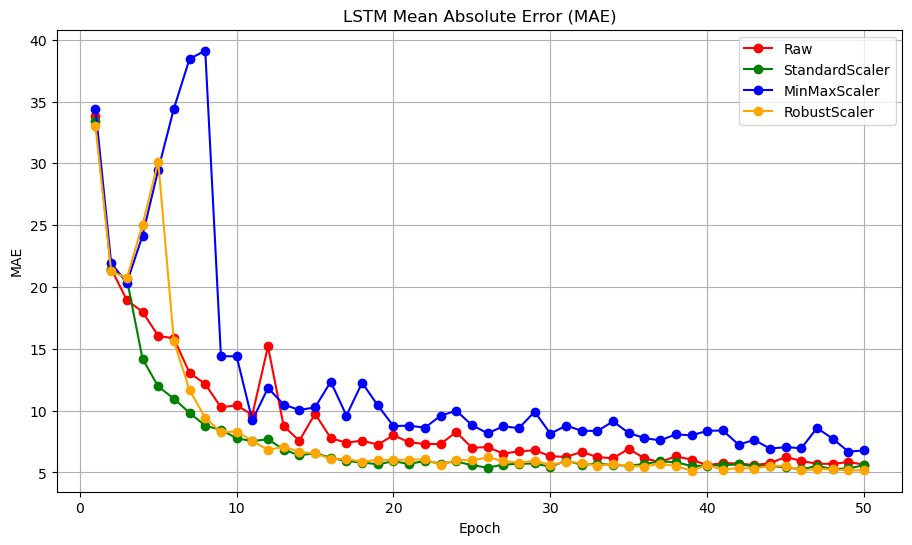

In [46]:
# Plot R-squared per epoch
plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 51), callback.mae_scores, marker='o', linestyle='-', color='r', label='Raw')
plt.plot(np.arange(1, 51), callback2.mae_scores, marker='o', linestyle='-', color='g', label='StandardScaler')
plt.plot(np.arange(1, 51), callback3.mae_scores, marker='o', linestyle='-', color='b', label='MinMaxScaler')
plt.plot(np.arange(1, 51), callback4.mae_scores, marker='o', linestyle='-', color='orange', label='RobustScaler')
plt.title('LSTM Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.legend()

plt.show()